Пропуски:
Series([], dtype: int64)

Итоговый размер датасета: 588101

--- SRM Check ---
Распределение:
test_group
ad     564577
psa     23524
Name: count, dtype: int64
Доли:
test_group
ad     0.96
psa    0.04
Name: count, dtype: float64


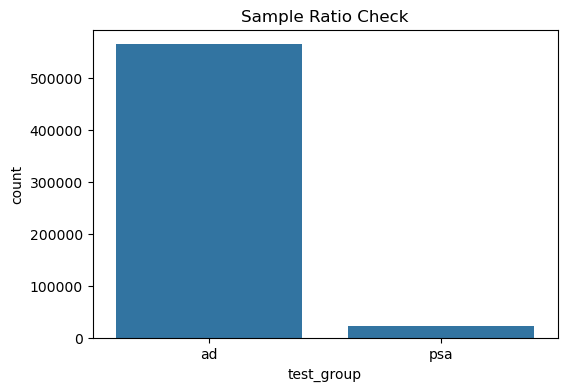

In [22]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка и очистка
df = pd.read_csv('marketing_AB.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

df.rename(columns=lambda x: x.strip().replace(' ', '_'), inplace=True)

# Проверка на пропуски и дубликаты
nulls = df.isnull().sum()
print(f"Пропуски:\n{nulls[nulls > 0]}\n")

user_groups = df.groupby('user_id')['test_group'].nunique()
contaminated_users = user_groups[user_groups > 1].index.tolist()

if len(contaminated_users) > 0:
    df = df[~df['user_id'].isin(contaminated_users)]
    print(f"Удалено пользователей с пересечением групп: {len(contaminated_users)}")

df = df.drop_duplicates(subset=['user_id'], keep='first')
print(f"Итоговый размер датасета: {len(df)}")

# Sanity Checks (SRM & A/A Check)
print("\n--- SRM Check ---")
group_counts = df['test_group'].value_counts()
print(f"Распределение:\n{group_counts}")
print(f"Доли:\n{group_counts / len(df)}")

plt.figure(figsize=(6, 4))
sns.countplot(x='test_group', data=df)
plt.title('Sample Ratio Check')
plt.show()


Результаты A/B теста (Сырые цифры):
            converted_users  total_users  conversion_rate  \
test_group                                                  
ad                    14423       564577         0.025547   
psa                     420        23524         0.017854   

            conversion_rate_perc  
test_group                        
ad                      2.554656  
psa                     1.785411  


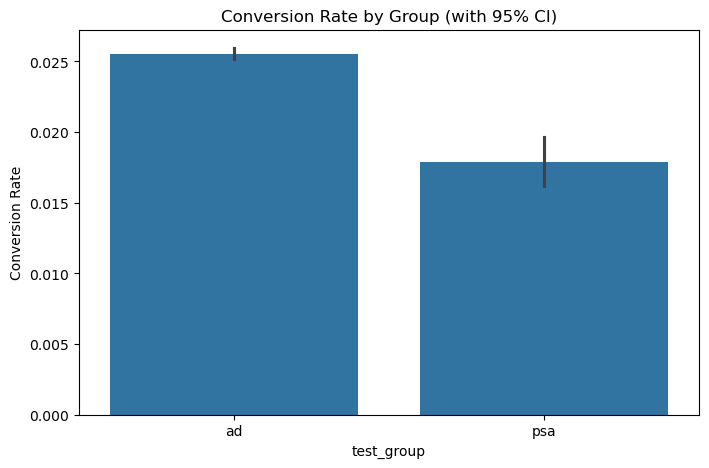


--- БИЗНЕС-МЕТРИКИ ---
Конверсия Ad: 2.5547%
Конверсия PSA: 1.7854%
Lift (Прирост): 43.09%

--- СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ (Chi-Square) ---
P-value: 1.9989623063390075e-13
✅ Различие СТАТИСТИЧЕСКИ ЗНАЧИМО. Реклама влияет на покупки.


In [ ]:
# ---АНАЛИЗ КОНВЕРСИИ ---

conversion_table = df.groupby('test_group')['converted'].agg(['sum', 'count', 'mean'])
conversion_table.columns = ['converted_users', 'total_users', 'conversion_rate']
conversion_table['conversion_rate_perc'] = conversion_table['conversion_rate'] * 100

print("Результаты A/B теста (Сырые цифры):")
print(conversion_table)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=df['test_group'], y=df['converted'], errorbar=('ci', 95))
plt.title('Conversion Rate by Group (with 95% CI)')
plt.ylabel('Conversion Rate')
plt.show()

# Расчет Lift
cr_ad = conversion_table.loc['ad', 'conversion_rate']
cr_psa = conversion_table.loc['psa', 'conversion_rate']

lift = (cr_ad - cr_psa) / cr_psa
print(f"\n--- БИЗНЕС-МЕТРИКИ ---")
print(f"Конверсия Ad: {cr_ad:.4%}")
print(f"Конверсия PSA: {cr_psa:.4%}")
print(f"Lift (Прирост): {lift:.2%}")

# Статистический тест Хи-квадрат

contingency_table = pd.crosstab(df['test_group'], df['converted'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\n--- СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ---")
print(f"P-value: {p_val}")

if p_val < 0.05:
    print("✅ Различие СТАТИСТИЧЕСКИ ЗНАЧИМО. Реклама влияет на покупки.")
else:
    print("❌ Различие НЕ значимо. Изменения случайны.")


In [17]:
from statsmodels.stats.proportion import proportions_ztest

ad_converted = df[df['test_group'] == 'ad']['converted'].sum()
psa_converted = df[df['test_group'] == 'psa']['converted'].sum()

ad_total = df[df['test_group'] == 'ad']['converted'].count()
psa_total = df[df['test_group'] == 'psa']['converted'].count()

count = np.array([ad_converted, psa_converted])
nobs = np.array([ad_total, psa_total])

# Запуск Z-теста
stat, p_val_z = proportions_ztest(count, nobs, alternative='two-sided')

print("--- Z-TEST FOR PROPORTIONS ---")
print(f"Z-statistic: {stat:.3f}")
print(f"P-value: {p_val_z}")

if p_val_z < 0.05:
    print("✅ Результат значим.")
else:
    print("❌ Результат НЕ значим.")


--- Z-TEST FOR PROPORTIONS ---
Z-statistic: 7.370
P-value: 1.7052807161559727e-13
✅ Результат значим.



--- BOOTSTRAP FOR LIFT ---
Средний Lift по бутстрепу: 43.55%
95% Доверительный интервал (CI): [30.25%, 58.13%]


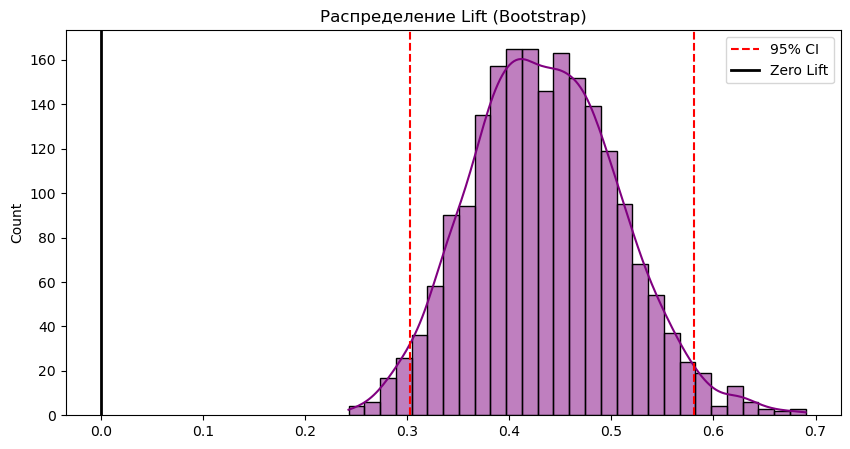

In [23]:
# --- BOOTSTRAP Анализ ---
print("\n--- BOOTSTRAP FOR LIFT ---")


ad_data = df[df['test_group'] == 'ad']['converted'].astype(int).values
psa_data = df[df['test_group'] == 'psa']['converted'].astype(int).values

iterations = 2000 
boot_lift = []

np.random.seed(42)

for i in range(iterations):
    ad_sample_mean = np.mean(np.random.choice(ad_data, size=len(ad_data), replace=True))
    psa_sample_mean = np.mean(np.random.choice(psa_data, size=len(psa_data), replace=True))
    

    current_lift = (ad_sample_mean - psa_sample_mean) / (psa_sample_mean + 1e-10)
    boot_lift.append(current_lift)


ci_lower = np.percentile(boot_lift, 2.5)
ci_upper = np.percentile(boot_lift, 97.5)
mean_lift = np.mean(boot_lift)

print(f"Средний Lift по бутстрепу: {mean_lift:.2%}")
print(f"95% Доверительный интервал (CI): [{ci_lower:.2%}, {ci_upper:.2%}]")

plt.figure(figsize=(10, 5))
sns.histplot(boot_lift, kde=True, color='purple')
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI')
plt.axvline(ci_upper, color='red', linestyle='--')
plt.axvline(0, color='black', linewidth=2, label='Zero Lift')
plt.title('Распределение Lift (Bootstrap)')
plt.legend()
plt.savefig('boot.pdf')
plt.show() 


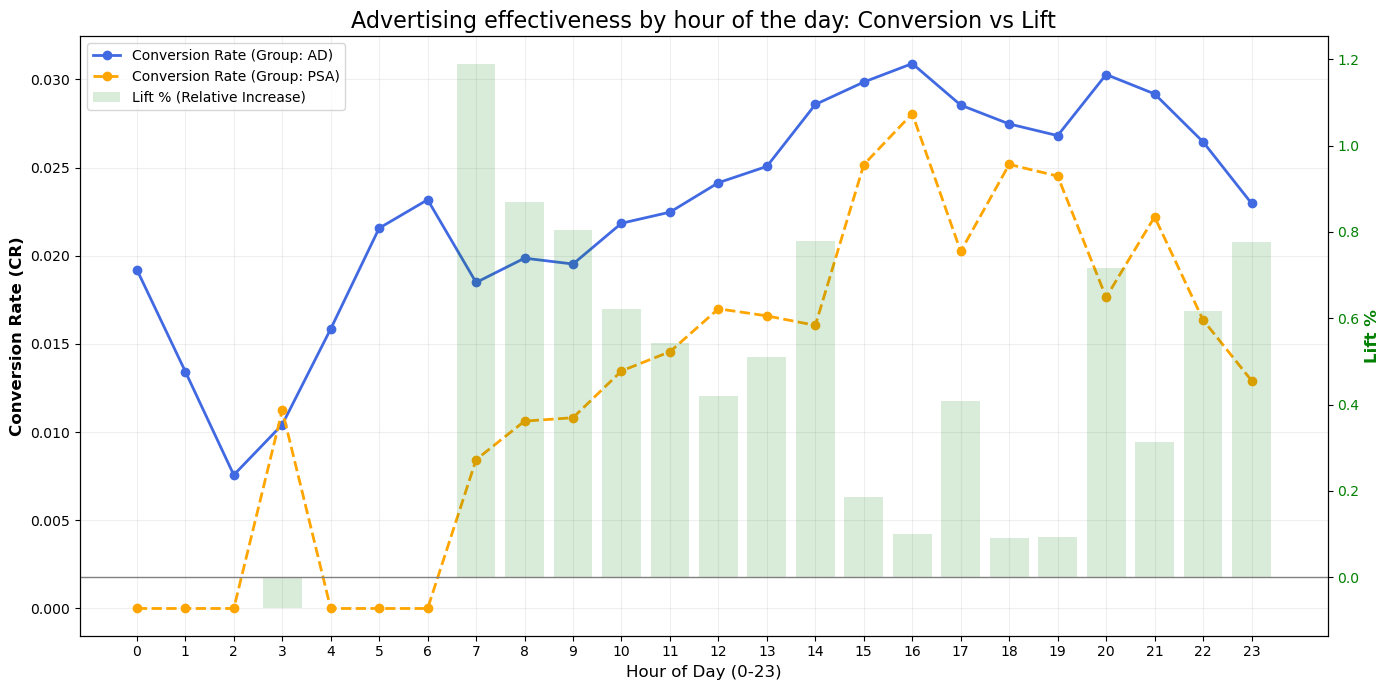

In [24]:
# --- Почасовой анализ ---
import matplotlib.patches as mpatches

hourly_conv = df.groupby(['most_ads_hour', 'test_group'])['converted'].mean().unstack()
hourly_lift = (hourly_conv['ad'] - hourly_conv['psa']) / hourly_conv['psa']

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(hourly_conv.index, hourly_conv['ad'], color='royalblue', marker='o', linewidth=2, label='Conversion Rate (Group: AD)')
ax1.plot(hourly_conv.index, hourly_conv['psa'], color='orange', marker='o', linewidth=2, linestyle='--', label='Conversion Rate (Group: PSA)')

ax1.set_ylabel('Conversion Rate (CR)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hour of Day (0-23)', fontsize=12)
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.2)

ax2 = ax1.twinx()
bars = ax2.bar(hourly_lift.index, hourly_lift, alpha=0.15, color='green', label='Lift % (Relative Increase)')
ax2.set_ylabel('Lift %', fontsize=12, color='green', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='green')


ax2.axhline(0, color='gray', linewidth=1, linestyle='-')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True, fontsize=10)

plt.title('Advertising effectiveness by hour of the day: Conversion vs Lift', fontsize=16)
plt.tight_layout()
plt.savefig('hours.pdf')
plt.show()


C:\Users\andr5\AppData\Local\Temp\ipykernel_22004\167047988.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_conv_detailed = df_freq[df_freq['test_group'] == 'ad'].groupby('ads_bucket_detailed')['converted'].mean()
C:\Users\andr5\AppData\Local\Temp\ipykernel_22004\167047988.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_counts = df_freq[df_freq['test_group'] == 'ad'].groupby('ads_bucket_detailed')['user_id'].count()


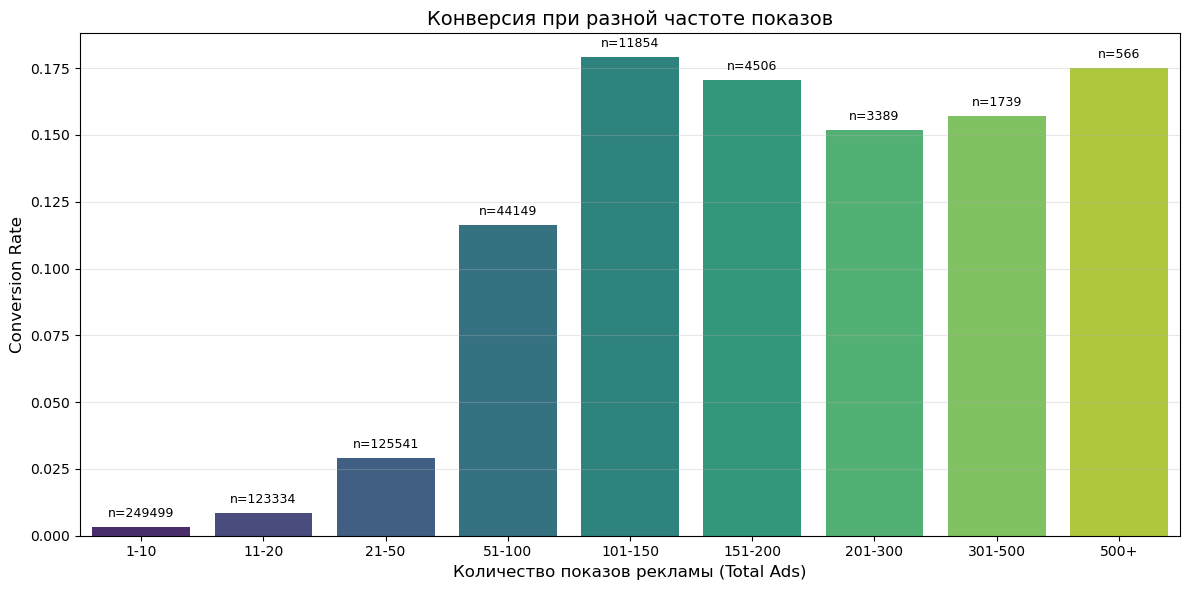

In [20]:
# --- Анализ частоты показа---

bins = [0, 10, 20, 50, 100, 150, 200, 300, 500, 10000]
labels = ['1-10', '11-20', '21-50', '51-100', '101-150', '151-200', '201-300', '301-500', '500+']


df_freq = df.copy()
df_freq['ads_bucket_detailed'] = pd.cut(df_freq['total_ads'], bins=bins, labels=labels)


freq_conv_detailed = df_freq[df_freq['test_group'] == 'ad'].groupby('ads_bucket_detailed')['converted'].mean()


freq_counts = df_freq[df_freq['test_group'] == 'ad'].groupby('ads_bucket_detailed')['user_id'].count()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=freq_conv_detailed.index, y=freq_conv_detailed.values, 
            hue=freq_conv_detailed.index, legend=False, palette='viridis', ax=ax1)

ax1.set_title('Конверсия при разной частоте показов', fontsize=14)
ax1.set_ylabel('Conversion Rate', fontsize=12)
ax1.set_xlabel('Количество показов рекламы (Total Ads)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Добавляем подписи количества людей над столбцами (чтобы видеть, не слишком ли мала выборка в хвосте)
for i, p in enumerate(ax1.patches):
    count = freq_counts.iloc[i]
    if count > 0: # Пишем только если есть люди
        ax1.annotate(f'n={count}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()


Распределение пользователей и конверсии по частоте показов:
                     users_count  conversion_rate_perc
ads_bucket_detailed                                   
1-10                      249499                  0.33
11-20                     123334                  0.84
21-50                     125541                  2.92
51-100                     44149                 11.63
101-150                    11854                 17.91
151-200                     4506                 17.07
201-300                     3389                 15.20
301-500                     1739                 15.70
500+                         566                 17.49
--------------------------------------------------


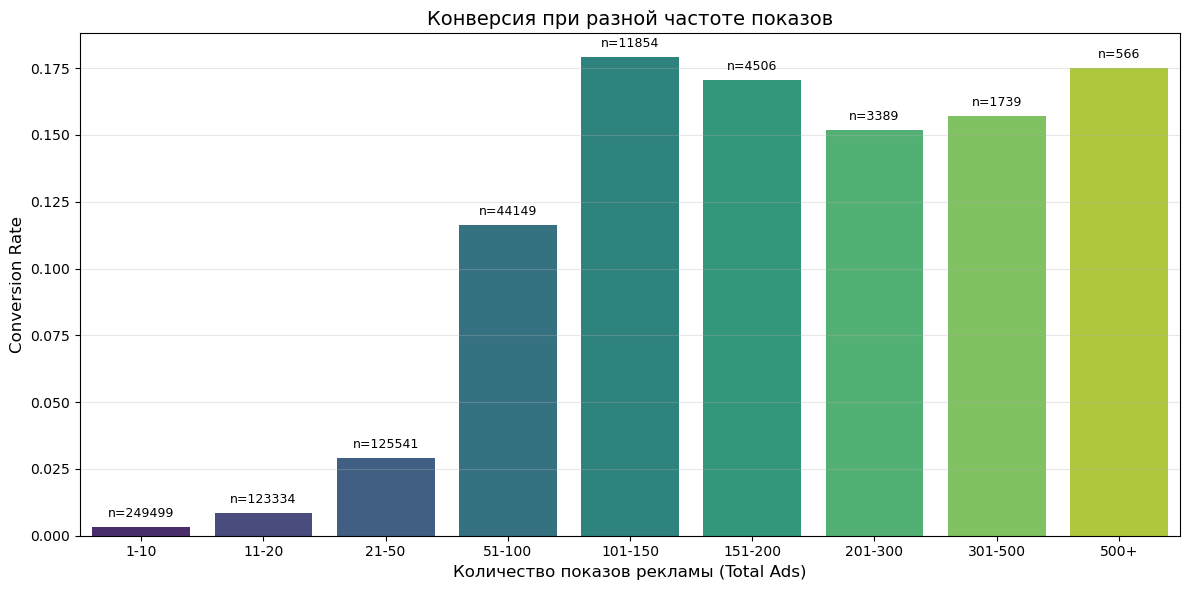

In [26]:
# --- Анализ частоты показа (С выводом таблицы) ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Задаем бакеты
bins = [0, 10, 20, 50, 100, 150, 200, 300, 500, 10000]
labels = ['1-10', '11-20', '21-50', '51-100', '101-150', '151-200', '201-300', '301-500', '500+']

# 2. Подготовка данных
df_freq = df.copy()
df_freq['ads_bucket_detailed'] = pd.cut(df_freq['total_ads'], bins=bins, labels=labels)

# 3. Агрегация данных (Считаем и конверсию, и количество людей сразу)
# observed=False добавлено, чтобы убрать warning в новых версиях pandas
freq_stats = df_freq[df_freq['test_group'] == 'ad'].groupby('ads_bucket_detailed', observed=False).agg(
    users_count=('user_id', 'count'),
    conversion_rate=('converted', 'mean')
)

# Переводим конверсию в проценты для красоты
freq_stats['conversion_rate_perc'] = freq_stats['conversion_rate'] * 100

# --- ВЫВОД ТАБЛИЦЫ В КОНСОЛЬ ---
print("Распределение пользователей и конверсии по частоте показов:")
print(freq_stats[['users_count', 'conversion_rate_perc']].round(2))
print("-" * 50)

# 4. Визуализация
fig, ax1 = plt.subplots(figsize=(12, 6))

# Рисуем барплот
sns.barplot(x=freq_stats.index, y=freq_stats['conversion_rate'], 
            hue=freq_stats.index, legend=False, palette='viridis', ax=ax1)

ax1.set_title('Конверсия при разной частоте показов', fontsize=14)
ax1.set_ylabel('Conversion Rate', fontsize=12)
ax1.set_xlabel('Количество показов рекламы (Total Ads)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 5. Добавляем подписи (Аннотации)
# Используем данные прямо из freq_stats, чтобы гарантировать совпадение
for i, p in enumerate(ax1.patches):
    # Берем количество пользователей для текущего столбца
    # Убедимся, что идем по порядку индексов
    bucket_label = freq_stats.index[i]
    count = freq_stats.loc[bucket_label, 'users_count']
    
    if count > 0:
        ax1.annotate(f'n={count}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5), 
                     textcoords='offset points')

plt.tight_layout()
plt.savefig('conv.pdf')
plt.show()
